# Warped signal modelling evaluation

This notebook uses the trained AR models to predict the warped frequency components and transforms the predictions back to the time domain.

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using LAR.DataAR
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/obama.wav"      # specify sound location
fs_desired = 8000                 # specify desired sampling frequency

# signal warping
nr_taps_warped = 32                # number of taps of warped filter bank
z_pole = 0.4092                    # pole location of all-pass filter segments (0.5756 ~ approximation Bark scale)
window = rectangularwindow         # specify windowing function from fourier.jl file

# inference and modelling
AR_order = 20                       # order of auto-regressive model
iterations = 3                     # number of iterations for variational message passing
Λ_meas = 1e10                      # assumed precision of measurement noise

# load model parameters
load_file = "../inferred_values/speech_AR_20.h5" # file in which model parameters are present
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[23*fs_time+1:26*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQDyMaa7RGOovHHJITxKdk09UghaPZUZ6zwCpbi8Zi48vfFWF72mSQe9TJ13vRNUvb1qd+S9/bKavbleBb3o/Xu8yc21vKP1Mb3CFY693zEUvex5WrvkfAy8hBWyuyZTs7zu9Pi7B4m5PDUstDwCFfq6/dwDvabvSr3GHY282Ed/PRjplT16oKY9YaplPUZWFj127XA9m7N7PTUtKj3RoJ08FEKBvI7Y0rveD+w8/S2HPG67FTvI9bm8sYdSveaCHr2KGe06DuoIvEE467wlin+9r0iPvWWvZLxTJqw8Jm7CPAQjLLlO/Va9uJE9vY0nbbqsHio9TQYqPX78/zyp45w86YDaPFgbaz3zBTs97UzHPAbc9Lm1u6e8FEryPCg2lz1yWYU9tTGCPZAFJj04CSk9gNiOPXMYmT0+eys9PDEHuvccM73Gcu+8R8fdOwnt4DpUmfi8LAK0veCNwr2ztgm9LzzQPLLuAz1UI1u8OYJjvUD5WL2JCSS8ZtFAPByMmLzuEm69B+uLvSMqBr3FdiY9bNJ3PV9xQD3YdQg8pRVlvErYt7rjquI8krZuuT5mVr1pJJ+9w+ukvUMPw7xOfwe7CRVevMHvUL3y4Km97jxlvX0Ulzs5Cd08+oUHPRe58LsNs+C8NSP8u6NiCT3bnhQ9WGc3vMJeRL2rWzS9uoSDPE9cdj1CIkI9qqC7PFHFB7wLecc7deSMPfe7jz26cis9WAMSvIRlTL3nMhu9sBrqux7qL7wMnB69lZKfvSUQp708D0K8vGbQPHSHnjyu65i8r1KAvdkffb1enwW9mmBaPKV5Djy4JSy8kzHhuzj3Aj1VcJw9tFSQPdusAT37ImQ7/tVBu3v/+DybT4c939p9PbuwHT3/SPk8m5orPULDqj1LzJQ9dx/CO9k7Xr2vY7W9JE9Kvdq1Ljwm/IE4gkkyvZILvL10oOC9+yVNvfL6a7xsMoG8c8SSvcs2wr3qWX+9etSVO+uo1jwGugO704DxvNg5Rr3TUdG8NRXsO/K2KTwcZ/a7ptqovC8FIbxabg49IyymPZqQiD07UxU9otdZPG2YqzylWJU9rGecPWewTT2zXMI7bz8ovRaxF73fe1G7l6GxPGDMczwkMwS9/L5MvQP8/Lz1xWS7qFBgus8WMb0kXIy9oeWGvVhjebw2o6s8ibIsPEFZprykuPq8224/vBmdhDzV9ic9mOYLPKlgb7x+uSy9u8z3u/r6Fz0sdSU9CJqEPJ0bxDubmcS7L1HKPEiEKT0RcxA9P/lIPCfz4Lvmzt67KrbYPDOsLD09R8c5xiINvfXgjr2y31S9+TyyvOk3hrsTyWu8fNHWvPEJgLwWco06J5jGPHL30DmXA+68/CtfvdlpUL3OKkK8smtLPMid0bqerNG8YBHWvCKMeryK8nQ8pgDIPGdXFTqdkSO9Hrx1vSFrlb3gnSO99zQlvZR5b73QVYO95al8vcsUM738gB66XfNbPKND0jz2RAU97pW/PHDBEz2WaEI9N98hPauc6TwWYZA8PD9nPJIDJD1HsM08DJURPVjY7jyz/gU9E/5ZPfoOaD05CXE9eWouPdRLCD3nAxo9f3MvPNvF3bt6nF68WEI1vTvXJb3En0+9/QtIvYG59bzlTq+8BcccvBBP3DqOu9y7cj+rvOpr/bwPcYa9DzyKvS+PJr0Z46M7DtdUPcobjj0ds3A9Z+VOPRWe2zxDH5I8PN8uPFX8AjxTrps8WbgYPVooXT1FED89cKEEPWFMPTyWG+m7rU/vvB2BKb3bXoG9QTohvRfzzbyLV1G78EgSvHmFsbwk2hW9kS8QvVmmYb0cQ669VDHavSm1s70kG8y7Re5SPfs1gz0RJwo98nEcPBUBQ7w/4OS8GSUtvTVxZL2GQmG9faC0vGniAj1wNWo9k/SFPcYOqjyDcGE7chhGutrQ7bp9qgI8o5GpPNbn9jydNBo9J7PvPF4xlDu974c6nV85vPh9D7xd3KC8ZW0Zvf/G8bzumC08ueFwPZ7Ljz0/4CA9IGavO6E6lrwmuBK9CNQ+vRciTr1znZ683GLDPBZogD130Jk95eCFPY4zDriRObu8LRn4vGXT6byQIcC7IcIeOr6zNDyZWxw9JwXePBRmwjzPi6A8/LUYujSrI7zI7KC8aQb/vJt3OjqPkHw8YJorPQzNEj2xyAo8Z3VrvE2FzrzlwwG9q2MDvYJL0LwL2HW8HP1jPGrALT0GPIo9dDuBPacfKzzCsSC9QfR3vaEVcb1yhhq9mxSyvHsSrjqkGgU8hoh/O2+Akzz6sWM8hXmdvMBrgr3tT9q9reHQvaVSqL0xLSa9SNKRvIJzmbzvdL+8FicVvcu2RL2JyE69wWFkvQk70ryvRUE7hL1CPcqShD2qZ309bmMmPaNkQjySBI28RBB2vHdaZDkQmSU9uUx3PYjOeT2so4w94PQ8PXNXDj2qv888r9oaO7/3q7yeWR69w+IyvVk+o7zSR+K8qbAQvdP/Yr1evnG9sndGvbelKr2vnT695TOAvRpyar0np/S837h3O+6YTDz2OaU7XFfZOj72xjxRISM9GtAhPXYkQj1qMkM9ompVPXe/eD0FlYs9kFOAPaBNXz01Egc9vBHzPOSzrDzSO4c8vTOUO3U5GbzWzZe8by7avODAAL06ZAm9pVcFvTZGr7xVxvu88eEfvdyfGb3wlWq9G6+HveYDnL07NHe9xS60vHf2RDzYQ/M8Wi+zPM4QBjxndIA6zv7Muz0rhLzeGme8y0OJvB0nwbzrbxK7wYzcPDPUGT31r+w8BG2JPEspZjz0pQ48symAOZir57x98+y8Yxn5vAeu0bwfajS8avf8uzxwxLx2awi94xoevT0pMb3LCDy9854DvTVF+bslW488gILyPGBw+jwFUs484PKqOzfulby3Cty8UDYLvbxmvbyBGrG7el3mPH6vLz04ZWM9doNJPda5BD3IG/W6wn/jvHWYFL17/fC8+NQvuzy/6TwoRDQ9fhJIPS0aDj0U5bI8e+ldu6m1sbxgxhu9x2cyvU7KFr2JXKq80F2uu20WqjwgOqE8WaErPHDVrryIq0C9j9MuvUubBb1Qupm8DP+KO6gXdTzxP+07qsamO1JMobzdQxK92ahsvW3lb71y3S69kjL0vDPVZLzuhlw75cmqPO/l2jzZxZk8xOOPvH5aS71NQJm9MdWUvf9PLr1skM+78+RDPJ500jz7Q8Y8Icu8PFDSszwwU4U8QDfEPKYICz2D/E49eXF9PfRSgT0eQmI994UBPXoizjyPxEk8NCe8PL1JLT0DWDo9gvpnPe+8ej3tfTw92wWUPGQOurv00fm8uu8HvQ+EgLxSS3y8JtuXvAir5bwTGQ69vfO8vNqKp7zxn4C8c1j6uybFKbyxYam53mwFPIYWHDwmZ+88UV+qPFVQ0TubFkG7aB7Vu6GSj7q7YD08haavPMeQ+jypyQ499YXXPDNf+TyMv548esLtOybB0rv2yS+8adRpuzJuzzvHSWQ8EokLO7GqXbvhBXS8bbs3vAve27yDSgO9PQoXvQEdDr2aNaC8/tupvEWaubzz3ce8JxXEvFsU9LuzR9U7maUOO33NvTsOQhK8XHLsvFPjE71Uyxa9+YEUvRwOwbypANS8HFEgvC2+aLtHZQG7Lvt7OwTcdjr7fyw7UTZ5PMv7H7tqJ2i7nz+9vFqaEr2VU6u8wmS1u6NVvrrbbU85ZQurvJqGD7w+9g08TEMDPBq4gzyFIuo8AcrwPLGD4jyN2oM8TR6NPK8ZSDz9PEC71YNzvInjwryJpuC8KZ7TvEfGMrwVAAY8ah7mPBsMvzz6hJc8YWelOcDCQ7wCfpq8tHBKvEwTD7sVZzw8NJhHPE9yYzxnr

## Visualize data

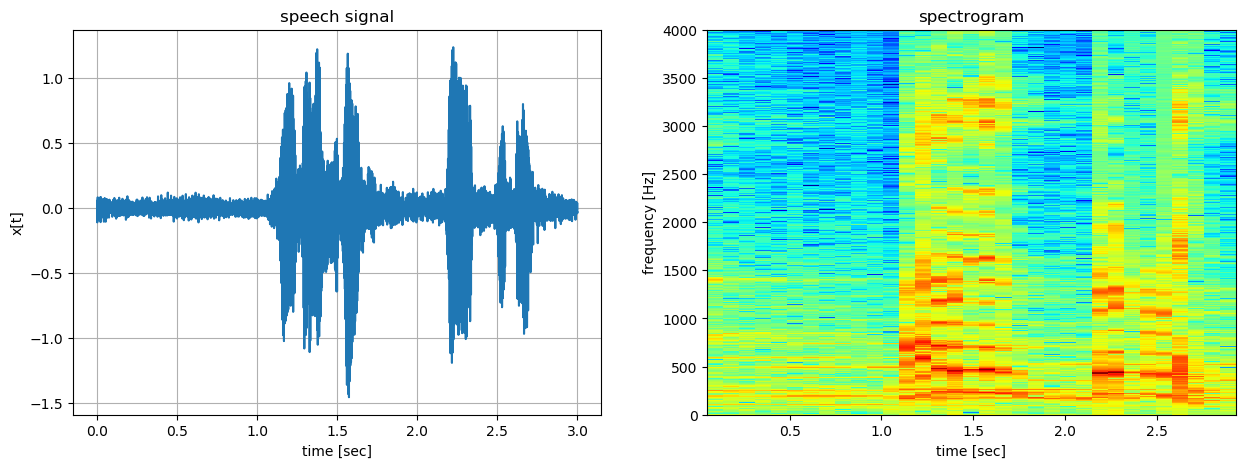

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Warp signal and calculate warped frequency distribution

In [5]:
# initialize memory vector of taps, Y, with zeros
Y = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps = Array{Array{Float64,1}}(undef, length(x_time))
mem_spec = Array{Complex{Float64},2}(undef, length(x_time), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_time)
    
    # update memory vector of taps and taps themselves
    Y, mem_taps[k] = allpass_update(x_time[k], Y, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec = mem_spec[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
mem_spec_all = hcat(mem_spec_real, mem_spec_imag)

# output signal
filter_output = [mem_taps[k][end] for k = 1:length(mem_taps)]
;

## Warped spectral distribution visualization

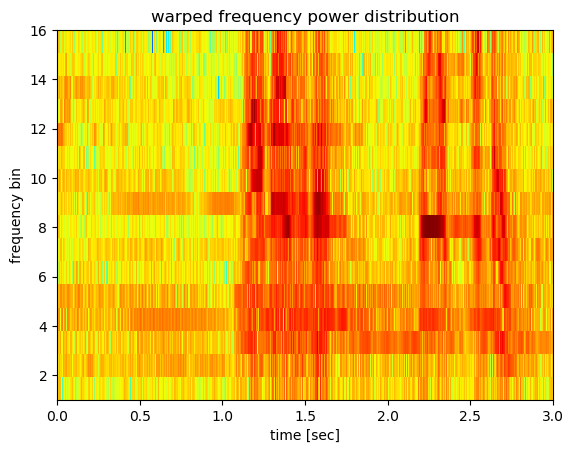

In [6]:
# calculate power of spectral components
mem_spec_pwr = 20*log10.(abs.(mem_spec))'

# plot warped power spectrum
plt.imshow(mem_spec_pwr, aspect="auto", cmap="jet", origin="lower", extent=[t[1], t[end], 1, Int(floor(nr_taps_warped/2))]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
;

## Generative model

In [7]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.AR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x + v
placeholder(y, :y)

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3849266678214484074 -->
 3849266678214484074 
 
 placeholder_μ_Sprev 
 
<!-- 17873306918366864921 -->
 17873306918366864921 
 
 placeholder_Λ_θ 
 
<!-- 11017300809799417314 -->
 11017300809799417314 
 
 placeholder_b_γ 
 
<!-- 16826439147619664141 -->
 16826439147619664141 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 16955373911372395705 -->
 16955373911372395705 
 
 clamp_3 
 
<!-- 16826439147619664141--16955373911372395705 -->
 16826439147619664141--16955373911372395705 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 137804085192487370 -->
 137804085192487370 
 
 clamp_2 
 
<!-- 16826439147619664141--137804085192487370 -->
 16826439147619664141--137804085192487370 
 
 clamp_2 
 1 out 
 2 m 
 
<!-- 6811869894758834937 -->
 6811869894758834937 
 
 AR 
 autoregressive_1 
 
<!-- 10487494735204066187 -->
 10487494735204066187 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 6811869894758834937--10487494735204066187 -->
 6811869894758834937--10487494735204066187 
 
 θ 
 1 out 
 3 θ 
 
<!-- 10384969000734580104 -->
 10384969000734580104 
 
 Gam 
 gamma_1 
 
<!-- 6811869894758834937--10384969000734580104 -->
 6811869894758834937--10384969000734580104 
 
 γ 
 1 out 
 4 γ 
 
<!-- 11487867306232955542 -->
 11487867306232955542 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 6811869894758834937--11487867306232955542 -->
 6811869894758834937--11487867306232955542 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 10424463728887579866 -->
 10424463728887579866 
 
 placeholder_μ_θ 
 
<!-- 16922842645374843058 -->
 16922842645374843058 
 
 + 
 addition_1 
 
<!-- 16922842645374843058--16826439147619664141 -->
 16922842645374843058--16826439147619664141 
 
 v 
 1 out 
 3 in2 
 
<!-- 1555142812444205234 -->
 1555142812444205234 
 
 dot 
 dotproduct_1 
 
<!-- 16922842645374843058--1555142812444205234 -->
 16922842645374843058--1555142812444205234 
 
 x 
 1 out 
 2 in1 
 
<!-- 7438123438114685368 -->
 7438123438114685368 
 
 placeholder_Λ_Sprev 
 
<!-- 10487494735204066187--17873306918366864921 -->
 10487494735204066187--17873306918366864921 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 10487494735204066187--10424463728887579866 -->
 10487494735204066187--10424463728887579866 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 9218538802147795990 -->
 9218538802147795990 
 
 clamp_1 
 
<!-- 10384969000734580104--11017300809799417314 -->
 10384969000734580104--11017300809799417314 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 8476555154573680290 -->
 8476555154573680290 
 
 placeholder_a_γ 
 
<!-- 10384969000734580104--8476555154573680290 -->
 10384969000734580104--8476555154573680290 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 1555142812444205234--6811869894758834937 -->
 1555142812444205234--6811869894758834937 
 
 S 
 1 y 
 3 in2 
 
<!-- 1555142812444205234--9218538802147795990 -->
 1555142812444205234--9218538802147795990 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 5777287509634132924 -->
 5777287509634132924 
 
 placeholder_y 
 
<!-- 5777287509634132924--16922842645374843058 -->
 5777287509634132924--16922842645374843058 
 
 y 
 1 out 
 1 out 
 
<!-- 11487867306232955542--3849266678214484074 -->
 11487867306232955542--3849266678214484074 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 11487867306232955542--7438123438114685368 -->
 11487867306232955542--7438123438114685368 
 
 Λ_Sprev 
 1 out 
 3 w

In [8]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S, Sprev, ids=[:S :Sprev])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorith 
eval(Meta.parse(algo))

# create prediction function for predicted next sample (process noise variance does not seem to be learned properly)
function predict_x(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 3))

    messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=0), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=1.0e10))
    messages[2] = ruleVariationalAROutNPPP(nothing, marginals[:Sprev], marginals[:θ], marginals[:γ])
    messages[3] = ruleSPDotProductOutNPG(nothing, Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0]), messages[2])
    
    return messages[3]
    
end
;

## Load parameters

In [9]:
# placeholder for parameters
params = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, size(mem_spec_all)[2])

# load parameters
for k = 1:size(mem_spec_all)[2]
    if k <= size(mem_spec_all)[2]/2
        
        # load parameters of real coefficients
        params[k] = h5read(load_file, "bin_real_"*string(k, pad=2))     
        
    else
        
        # load parameters of imaginary coefficients
        params[k] = h5read(load_file, "bin_imag_"*string(k-Int(size(mem_spec_all)[2]/2), pad=2))     

    end
end
;

## Perform inference

In [10]:
# create placeholders for current values
current_μ_Sprev = Array{Array{Float64, 1}, 1}(undef, size(mem_spec_all)[2])
current_Λ_Sprev = Array{Array{Float64, 2}, 1}(undef, size(mem_spec_all)[2])

# initialize marginals and data dictionaries
marginals = Array{Dict{Symbol, ProbabilityDistribution}, 1}(undef, size(mem_spec_all)[2])
data = Array{Dict{Symbol, Union{Array{Float64}, Float64}}, 1}(undef, size(mem_spec_all)[2])

# initialize priors
for k = 1:size(mem_spec_all)[2]
    
    # randomly initialize uninformative priors
    current_μ_Sprev[k] = randn(AR_order)
    current_Λ_Sprev[k] = tiny*diagm(randn(AR_order))
    
    # fill marginals/data with empty dictionary
    marginals[k] = Dict()
    data[k] = Dict()
    
end


# placeholder for spectral estimates
μ_s_pred = Array{Array{Float64,1}}(undef, size(mem_spec_all)[1])
Λ_s_pred = Array{Array{Float64,1}}(undef, size(mem_spec_all)[1])
for sp = 1:size(mem_spec_all)[1]
    μ_s_pred[sp] = Array{Float64, 1}(undef, size(mem_spec_all)[2])
    Λ_s_pred[sp] = Array{Float64, 1}(undef, size(mem_spec_all)[2])
end

# create progress bar
p = Progress(size(mem_spec_all)[1], 1, "Observed ")

# loop through signal samples
for sp in 1:size(mem_spec_all)[1]
    
    # update progress bar
    update!(p, sp)
    
    # loop through components
    for bin in 1:size(mem_spec_all)[2]
    
        # update marginals
        marginals[bin][:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params[bin]["theta_mean"], w=params[bin]["theta_precision"])
        marginals[bin][:γ] = ProbabilityDistribution(Univariate, Gamma, a=params[bin]["gamma_a"], b=params[bin]["gamma_b"])
        marginals[bin][:Sprev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current_μ_Sprev[bin], w=current_Λ_Sprev[bin])
        
        # update data dictionary
        data[bin] = Dict(:y => mem_spec_all[sp, bin],
                         :μ_Sprev => current_μ_Sprev[bin],
                         :Λ_Sprev => current_Λ_Sprev[bin])
    
        # perform prediction of current sample
        μ_s_pred[sp][bin] = ForneyLab.unsafeMean(predict_x(data[bin], marginals[bin]).dist)
        Λ_s_pred[sp][bin] = ForneyLab.unsafeVar(predict_x(data[bin], marginals[bin]).dist)
        
        # perform variational message passing iterations
        for it = 1:iterations
            
            # update data dictionary   
            data[bin] = Dict(:y => mem_spec_all[sp, bin],
                             :μ_Sprev => current_μ_Sprev[bin],
                             :Λ_Sprev => current_Λ_Sprev[bin])      
        
            # perform inference
            data[bin], marginals[bin] = step_all!(data[bin], marginals[bin])
            
            # update current parameters
            current_μ_Sprev[bin] = ForneyLab.unsafeMean(marginals[bin][:Sprev])
            current_Λ_Sprev[bin] = ForneyLab.unsafePrecision(marginals[bin][:Sprev])
            
        end
        
        # update current parameters
        current_μ_Sprev[bin] = ForneyLab.unsafeMean(marginals[bin][:S])
        current_Λ_Sprev[bin] = ForneyLab.unsafePrecision(marginals[bin][:S])
        
    end
    
end
;

DimensionMismatch: DimensionMismatch("dot product arguments have lengths 5 and 20")

## Convert predicted coefficients back to time signal

In [11]:
# convert predictions back to complex coefficients
fourier_coef = Array{Array{Complex{Float64},1},1}(undef, size(mem_spec_all)[1])
time_pred = Array{Array{Float64,1},1}(undef, size(mem_spec_all)[1])
# loop through all predictions
for sp = 1:size(mem_spec_all)[1]
    if nr_taps_warped%2 == 0
        # get real part of coefficients
        coef_real = μ_s_pred[sp][1:Int(length(μ_s_pred[sp])/2)]
        
        # get imaginary part of coefficients
        coef_imag = μ_s_pred[sp][Int(length(μ_s_pred[sp])/2)+1:end]
        
        # determine fourier coefs (DC=0, normal up to length-1, conj of length with order reversed, see fftfreq)
        fourier_coef[sp] = vcat(0, coef_real[1:end-1] .+ 1im*coef_imag[1:end-1], reverse(coef_real) .- 1im*reverse(coef_imag))

    else
        # to do
    end
end

# convert back to time domain (discard imaginary part, because of expected complex conjugacy)
for sp = 1:size(mem_spec_all)[1]
    time_pred[sp] = real.(FFTW.ifft(fourier_coef[sp]))
end

## Fetch expected input/output of warped filter bank and visualize

<source src="data:audio/wav;base64,UklGRqBnAQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YWRnAQBBY7M8vxsrPX49Wj2a/0Q9benuPDXWmTzvZDE5TfqPOluFGbpjlQ+8HzyOu2ZoYLqs/fg7vAJYPLKlALtakZ68Fp/0vJACG70NQvC8hD7ZvLELFryJjFW8a3GpvOjp97wg4Oq8UlmEvIE0QLwKR7K68XUgPMo2tzySPUo95gdjPfqFKj3akgk8LB2bvNkWprzfuky8T7v2ug0qr7vIBbi7w8LYOTPJSTzz24w8Ke8GPGYzu7yubwW9m4wSvYpIB71nnR+8WTF/vJtdrrwTScW8OLDovIxKd7y/hLe8yl3SvJyFubwSAjO8N55/O3UQmzwJgiM75DMQukM/0Ly0LwW9sHLavGqkm7xtDy48N60IPRb4XD0z0Hw9eYduPVENFD1cTfk7arCjvBGLx7x7tbm8+btWvFEEBLpetGe8gYSHvEK1crz9EGe8DsAbvJmv6rwgOi69Xj0wvU8tML3fmMS8D4HzvHvGHL2nSD29enN9vTEdXr2iYUC9CX4WvcLuH7xs7248U5I1PZvtUj0vMxY9kn5APKkKTDvRui08J5sNPbjONj2YI3Q9lDRoPaBRgj3SPqA93wiPPT1ceT0oJEI9XtOCPD9RFTskr8c45xmbu348CDxG+0m8XcD4vMRvO73bLWq9VUl4vdfoB71lq468tFiDPIG1Fj1wviU9HDEwPd74JDxgiOi8isMOvamzAr1EAEO7kzbVPDGUCj2XRB89Wt0nPXMsWT2qp1E9bdAqPUN6TjxvGdA7NSeNPDIGED1NvU49DpU0Pblegzw14ya8hxvyvAFSD724o+i8+oQjvaSEGL2pqea82EzXumLg6Dtwlqw6mE4SvYrXK72luyS9s3z+vKcOhrzYibi89pKhvMnBRbzDJes7oHetPExNNjw0N5u8h+86vTR7dL26jFq93CPvvLZ7E7zSGuC7oj8MvAARR7xUK668k56uvKwjHb2oySC9cUYhvZmBCb2iwpq8B2sxOut5HjyulZ+7lnWtu4HM3Lvt4EE8XI0BPRKpNz0ezSw9lKZBPfx4QD1CoTk94vopPUf4ETzL8nW8A1D2vANZKL3nlQy9sHfivK9w7rz17Kq6bKECPKjHHjxpgOc7lcIpvKH+abjvZSc8Pnd/PJdHvTwXhuo7jM6xvFvv/LxwIEK9jn8ivRPugbz3qIg7czrGPIXoHT10lgo9JT3jPPtUuzvWEWe8qZPQvGnQ+bwicMK82QGovBv6Vjs2TuQ7dUR2Oytcy7u5pne86+WtvCjqC71SoSm9f2/DvP+JS7vER5U8ILGvPJ+sCrzMDye9VwhWvU3lY70sQAy9QZvcvIqf0byNIWC8bxYdvNC1lTlSmqg7fKiJvKysAL1QyFC9j9ZhvajgGr0eubO8D5u9OnE6JD2o9jA9/wMxPfgePz0iLMc8os3RPFYXXjz8HA88wsO4PIZ4BD19HGQ9L56PPVQbeD0KiF89rinuPASQATwZvjW7klG4vHj447zm7qG8bsW6vDpCubx2Gsq8074HvQvkFL1qTjW9id0PvQm61rz1haO87Wl0u5CiVTwx1Hc84AsHO+GAo7u4FFa8DxpRuydtIzwx2jA8ow7pu/wdBbzEGsG7+O/vPAVFKz0MOSY9W6r3PM97SDz3C6w8vuS9PDTGfTyEhg68oCoAvW7zHr1PG5i8qjuLOF1XizxsBLM8aw2LPDpPkDzdcZ88NxXbOzXdZbyZHa68ciK2vG6rYrw+jA28YQHQu+Cj6TstT4c8TNRyPMxJSTnG8aO8bb6dvAx5T7xYxo68ELRBvKtcqrwNlBy9T0RAvXwAcL1SA1i9NPQrvRySlbyov7C7ys4MOw5iAbxHbWS8h7ZvvPR/7LvxBOu7jwEnvNyZALu39mc8M8oiPfpmVj3raV899vkTPeoXEz3NwLg8EBhPPE6Tbzuh/q86lbA/u+nbhDv3Mh87Na3pulB7bLzeeMG8zu+FvNbzUrxvz+i78BXHuyELgLuM4IQ8fDVqPJgWsTtx2kw7Xp+6utRAPrzD2J288avjvN1UL7yjyqA7nOybPPoJHT1ldhc9eYADPeFd+zwHK6U8Zv/VPKrwwDxd12c84CtUOumsxrt32lK8by4EvAm4FLwtyXe5O/xlOyROpLxLkBm9h6UzvTGGGr369pm80/wmvNpBJryIgO689B4cvYcNMb2wrQu9xZp3vB2HZLzAicS84jXJvMZI17w3psq8IRCnvFR72LxGIP28rzTIvMow6LvrWhY8RS+/O3V6Lrwfq5a8TQj/u5JHojxLMws9kwsSPWrN7TzqwAU9U7w1PV94Xz0y2l497Ts2PWI3NT10lDw995csPbVaej393YA9btQRPQ+q4Llt0ea8Pgk3vbzbjb2K4bu9I8CVvazt47ztzBc8coonPZfcAD1vfK87Vd11vB2BwzrOwK88qfrNO4nakbzT+aG7AeXZPPMR1DyP0988AfsLPWpokzztbnq83HxavEp0arsrqiU8R2kAPabDHT0IhBY9x00LPfnjvTxNbm28ZTtuvfDAor0Sd429BXljvRKS6bwuIHS8yGemvPJWibxfh828et8CvT9ME72Xxi+9v+JqvfUZh72fZWq9ZH7NvBJRvbv9QbU6blXtuyJDl7zhhQK9oKXuvGZfnrwjaba8aArfvOM4sLzsyu+834EBve6hCL3W3F29Myx8vbG/dL0BDV29wYgevdJcBL2J3p281y8ivF3qBbw72TY8wMBcPEGssTvzxhI85VN8PGeMLz1VX549Kxy3PfSErz2+g5Q9ydlhPVJzTz2SJEo9LUhXPVH+PD0ogTY9ivMAPV1yBT0yRYc8PJSLO0l3Ibz6gpe8bVBDvHXsJrv3vZw7cW9HOsMUorsOdyK8vWxHvJ41jLzExOa89eVQvU28ir0erFO9O1yYvJgAmTyz6Qk9U+G5PPuZajzu/j88Fh1VPJ4/Tzz5AW08Xk1kOwe6cjyg/nY8TpOPPBk/1juEVLs7wxc/O8FfZzxJ7VY8B31lPEKYgLulZMa8nHKCvNvQi7xRIcO8abcsvaDUh71mA4+9gS+Fvc3SU73nVaO8U6BbvCjeTry9c4m8L8a7vAq8xLyZdeK8zVosvfLGDb09Sg698S+rvAqd3rsXFVa8ZHMzvOh+rrodmNk7GnrrPCS3BT10sAA9GsRmPGEcQzyUiBA9LaZGPRmFdT04sUg9b709PeSPBT1Z3wA9OIYMPfq4CD1grI48HshcPOeRIDtDxau7loCUu1WccLwOQK28yLmUvB/Mjbsahbw7hC5nPOAijDzUGJQ8H5ejPHVeXTxPJ5M8nf9zPAy+hDtxpDk7HpOFPKfxUjwbvUQ8x9MFPJq2XLqc9LE6GmViPCLEozxphpc8z/RVO/i14jr2Q0a7nHUPvEuxibyGi968CxUovdwyPr12GeO8MHcau9etHjtRVQy6sYJGvMNRzry0gcq8VwI9vILOPbw0ap68VgINvTw467xTyA+8TFU4O4N7HzzGXWO7ii0qvEcNTrwaFNm7pX8xvJ4P8Lzf5Dm91khOvdIx8bwlToK8f8COvOds+rxHkDq9tRgVvYAU67zaeKa8nvy+vGxWj7zEv2o7r32tPJJBPj3BwjU9DjIiPVuPHT2IY+o88v1FPfq/RT08uUg9EvYXPYQE6jwydQg9M60SPSPiAT2STYc8tieku4Fznby3sa285hutvKYVY7x4S7C8rVimvCnppru4Y5g7bztiPMbJr7u0At+8I3YsvcchXb1FLV69YdINvZpV7ryqNQC9XyK7vMr0XrzYCus7IsQHPBbZa7qLdz+8WN59vLkraryCGlO8Z//cvO44Ar3+0pO8Qfz3u/SVFDyMBDk8POvkOoQnJrwEiT468SBlPPDXzjz2o

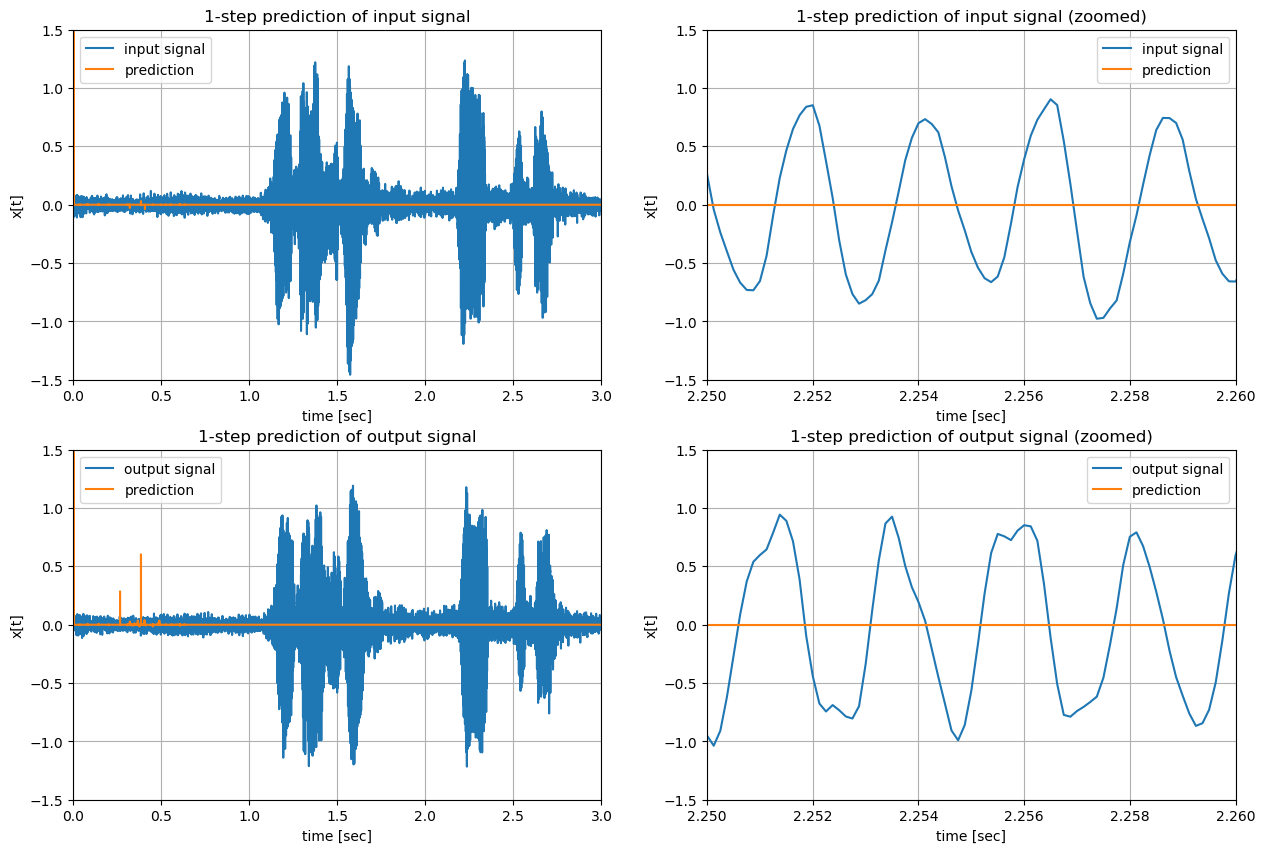

In [12]:
# get predicted input and output samples
pred_in = [time_pred[k][1] for k = 1:size(mem_spec_all)[1]]
pred_out = [time_pred[k][end] for k = 1:size(mem_spec_all)[1]]
true_in = [mem_taps[k][1] for k=1:size(mem_spec_all)[1]]
true_out = [mem_taps[k][end] for k=1:size(mem_spec_all)[1]]

# create figure
_, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,10), squeeze=true)

# plot predicted and actual input of warped filter bank
ax[1,1].plot(t, true_in, label="input signal"), ax[1,1].plot(t, pred_in, label="prediction")
ax[1,2].plot(t, true_in, label="input signal"), ax[1,2].plot(t, pred_in, label="prediction")

# plot predicted and actual output of warped filter bank
ax[2,1].plot(t, true_out, label="output signal"), ax[2,1].plot(t, pred_out, label="prediction")
ax[2,2].plot(t, true_out, label="output signal"), ax[2,2].plot(t, pred_out, label="prediction")

# change vizualization
ax[1,1].grid(), ax[1,1].set_xlim(0,3), ax[1,1].set_ylim(-1.5, 1.5), ax[1,1].set_xlabel("time [sec]"), ax[1,1].set_ylabel("x[t]"), ax[1,1].legend(), ax[1,1].set_title("1-step prediction of input signal")
ax[1,2].grid(), ax[1,2].set_xlim(2.25,2.26), ax[1,2].set_ylim(-1.5, 1.5), ax[1,2].set_xlabel("time [sec]"), ax[1,2].set_ylabel("x[t]"), ax[1,2].legend(), ax[1,2].set_title("1-step prediction of input signal (zoomed)")
ax[2,1].grid(), ax[2,1].set_xlim(0,3), ax[2,1].set_ylim(-1.5, 1.5), ax[2,1].set_xlabel("time [sec]"), ax[2,1].set_ylabel("x[t]"), ax[2,1].legend(), ax[2,1].set_title("1-step prediction of output signal")
ax[2,2].grid(), ax[2,2].set_xlim(2.25,2.26), ax[2,2].set_ylim(-1.5, 1.5), ax[2,2].set_xlabel("time [sec]"), ax[2,2].set_ylabel("x[t]"), ax[2,2].legend(), ax[2,2].set_title("1-step prediction of output signal (zoomed)")

# create audioplayers (remove first ~1000 to save your ears) {true in, predicted in, true out, predicted out}
from = 1000
audioplayers(true_in[from:end], pred_in[from:end], true_out[from:end], pred_out[from:end], fs=fs_desired)